- competition/dataset : [https://www.kaggle.com/c/porto-seguro-safe-driver-prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction)
- date : 2021/01/28
- original : [https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction](https://www.kaggle.com/gpreda/porto-seguro-exploratory-analysis-and-prediction)

## Porto Seguro Exploratory Analysis and Prediction

**✏ 필사 1회** 

## Introduction
이 노트북은 Port Seguro 대회 데이터에 대한 소개로 시작합니다. 그 다음, 교차검증과 스태킹을 사용하여 몇 가지 예측 모델을 준비하고 실행하고, 제출파일을 준비합니다.  

이 노트북은 다음 커널들을 참고했습니다:  
* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

## Analysis packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

## Load the data

In [6]:
trainset = pd.read_csv('../data/porto_train.csv')
testset = pd.read_csv('../data/porto_test.csv')

## Few quick observations
대회의 데이터 설명을 참고로 몇 가지 살펴볼 수 있습니다:  
* 정의된 그룹은 거의 없으며, 해당 그룹에 속한 feature들은 이름에 패턴이 있습니다. (ind, reg, car, carc) **ind**는 **individual**, **reg**는 **registration**, **car**은 설명이 따로 필요없고, **calc**는 **calculated** 필드를 나타냅니다.
* **bin**은 이진 feature에 사용합니다.
* **cat**은 범주형 feature에 사용합니다.
* **bin**이나 **cat** 지시자가 없는 feature들은 실수(연속값)이거나 정수(서수)입니다.
* 결측값은 **-1**로 표현됩니다.
* 예측해야 하는 값은 **target** 컬럼입니다. 이것은 해당 피보험자에 대한 클레임이 있었는지를 나타냅니다.  

이러한 해석이 맞는지 데이터를 잠깐 확인해봅시다.

In [4]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


**cat**의 값들은 범주형을, 정수형 값들은 **0**에서 **n**을, **bin**은 이진임을 확인할 수 있습니다.  

데이터의 행과 열에 대해 살펴보겠습니다.

In [9]:
print('Train dataset (rows, cols):', trainset.shape,
      '\nTest dataset (rows, cols):', testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


트레이닝 셋에는 59개의 컬럼이 있으며, 테스트 셋에는 58개만 있습니다. 테스트 셋에는 **target**이 없으므로 올바른 결과입니다. 두 데이터 셋의 컬럼들을 비교하여 다 정상인지 확인합니다.

In [10]:
print('Columns in train and not in test dataset:', set(trainset.columns)-set(testset.columns))

Columns in train and not in test dataset: {'target'}


## Introduction of metadata
데이터를 좀 더 쉽게 다루기 위해, 트레이닝 셋의 변수들에 몇 가지 메타정보를 연결합니다. 이를 통해 분석, 검사, 모델링을 위한 다양한 타입의 feature들을 쉽게 선택할 수 있습니다.  

* **use**: input, ID, target
* **type**: nominal, interval, ordinal, binary
* **preserve**: True or False
* **dataType**: int, float, char
* **category**: ind, reg, car, calc

In [40]:
data = []
for feature in trainset.columns:
    # use 정의
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input' 
    
    # type 정의
    if ('bin' in feature) or (feature == 'target'):
        type = 'binary'
    elif ('cat' in feature) or (feature == 'id'):
        type = 'categorical'
    elif (trainset[feature].dtype == float) or (isinstance(trainset[feature].dtype, float)):
        type = 'real'
    elif trainset[feature].dtype == 'int64':
        type = 'integer'
    
    # id를 제외한 모든 변수는 preserve = True
    preserve = True
    if feature == 'id':
        preserve = False
    
    # data type 정의
    dtype = trainset[feature].dtype
    
    # category 정의
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # 변수의 모든 메타데이터에 대한 딕셔너리 생성
    feature_dictionary = {
        'varname':feature,
        'use':use,
        'type':type,
        'preserve':preserve,
        'dtype':dtype,
        'category':category
    }
    data.append(feature_dictionary)

metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


예를 들어 모든 범주형 변수들을 출력할 수 있습니다.

In [41]:
metadata[(metadata.type == 'categorical')&(metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

모든 feature들을 검사하여 범주별로 값이 몇 개 있는지 살펴보겠습니다.

In [43]:
pd.DataFrame({'count':metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


calculated feature 20개, car 16개, individual 18개, registration 3개가 있습니다. 이번에는 use와 type이 얼마나 있는지 확인해보겠습니다.

In [44]:
pd.DataFrame({'count':metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


형식적인 feature 1개(id), 이진 컬럼 20개, 범주형 변수 16개, 실수형 변수 21개, 범주형 변수 16개가 있습니다.

## Data analysis and statistics

### Target variable

<Figure size 432x288 with 0 Axes>

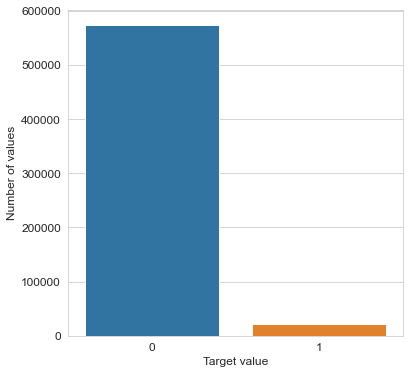

In [45]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values

sns.barplot(x, y, ax=ax)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

3.64%의 target 데이터만 값이 1입니다. 이것은 트레이닝 셋이 매우 불균형함을 의미합니다. 이럴 때 target = 0인 기록을 언더샘플링하거나 target = 1인 기록을 오버샘플링할 수 있습니다. 여기서는 매우 큰 데이터 셋을 사용하므로 target = 0을 언더샘플링하겠습니다.

### Real features

In [46]:
variables = metadata[(metadata.type == 'real')&(metadata.preserve)].index
trainset[variables].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [47]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [48]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

#### Features with missing values
**ps_reg_03**, **ps_car_12**, **ps_car_14**에는 결측값이 존재합니다.

#### Registration features
**ps_reg_01**, **ps_reg_02**는 분모가 10인 분모입니다.

#### Car features
**ps_car_12**와 **ps_car_15**는 제곱근입니다. 이제 변수들을 pairplot을 사용하여 나타내봅시다.

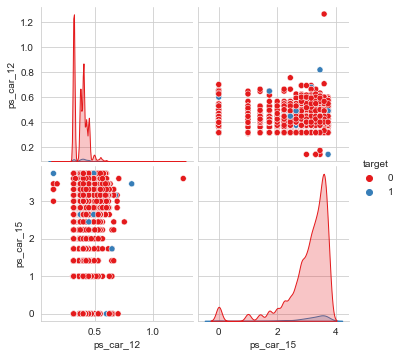

In [51]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

#### Calculated features
**ps_calc_01**, **ps_calc_02**, **ps_calc_03**은 매우 비슷한 분포를 가지고 있으며, 모두 최댓값이 0.9이므로 일종의 비율이 될 수 있습니다. 다른 calculated 변수들의 최댓값은 정수입니다.(5, 6, 7, 10, 12)  

실수형 변수들의 분포를 밀도 플롯으로 시각화해봅시다.

<Figure size 432x288 with 0 Axes>

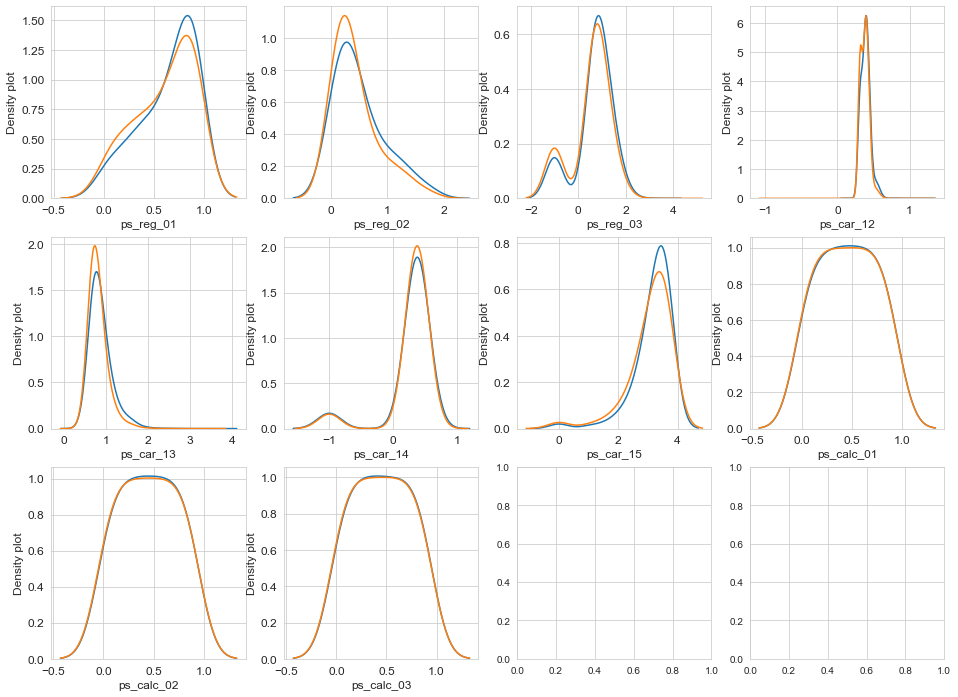

In [50]:
var = metadata[(metadata.type == 'real')&(metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

**ps_reg_02**, **ps_car_13**, **ps_car_15**는 ```target = 0```과 ```target = 1```의 분포가 가장 차이가 납니다.  

실수형 feature들의 상관관계에 대해 시각화해봅시다.

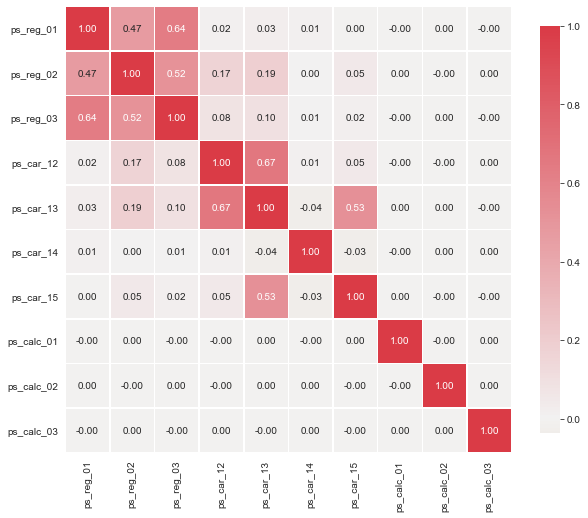

In [52]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # 두 색갈 사이의 범위 색상 생성
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f', square=True,
                linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show()

var = metadata[(metadata.type == 'real')&(metadata.preserve)].index
corr_heatmap(var)

* ps_reg_01, ps_reg_02: 0.47
* ps_reg_01, ps_reg_03: 0.64
* ps_reg_02, ps_reg_03: 0.52
* ps_car_12, ps_car_13: 0.67
* ps_car_13, ps_car_15: 0.53  

pairplot을 사용하여 상관관계가 있는 변수의 쌍들을 볼 수 있습니다. 그 전에, 표본의 2%만 하위 표본으로 취할 것입니다.|

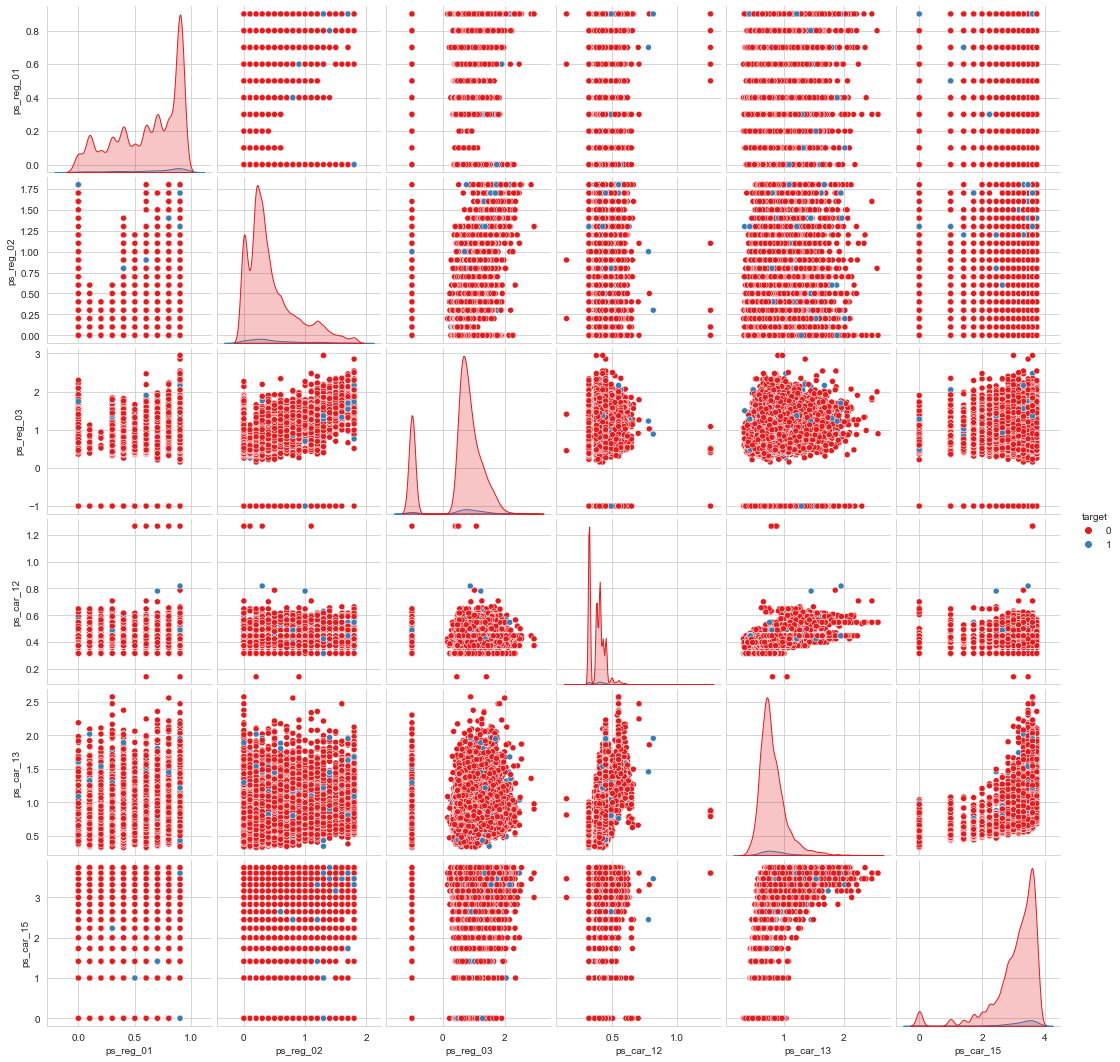

In [55]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### Binary features

In [56]:
v = metadata[(metadata.type == 'binary')&(metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


트레이닝 셋의 이진 데이터에 대한 분포를 시각화해봅시다. 파랑은 0의 비율, 빨강은 1의 비율을 나타냅니다.

<Figure size 432x288 with 0 Axes>

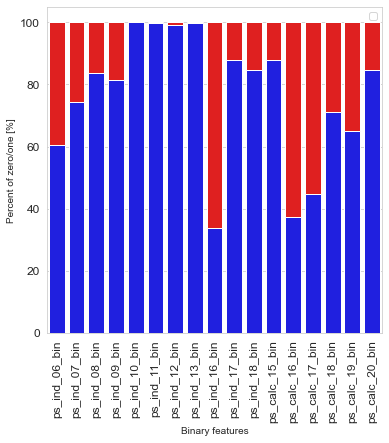

In [61]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col] == 0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col] == 1).sum()/trainset.shape[0]*100)

plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color='red')
plt.ylabel('Percent of zero/one [%]')
plt.xlabel('Binary features')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()